In [ ]:
import matplotlib.pyplot as plt
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from time import time
from tqdm import tqdm

import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

In [2]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    y = torch.log_softmax(logits, dim=-1) + sample_gumbel(logits.size())
    return torch.softmax(y / temperature, dim=-1)


def gumbel_softmax(logits, temperature=1e-5):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y


def gumbel_sigmoid_sample(logits, temperature):
    # See https://davidstutz.de/categorical-variational-auto-encoders-and-the-gumbel-trick/
    u = torch.rand_like(logits)
    # we exploit the fact log(sigma(x)) - log(1-sigma(x)) = x
    y = logits + torch.log(u) - torch.log(1 - u)
    
    return torch.sigmoid(y / temperature)


def gumbel_sigmoid(logits, temperature=1e-5):
    """
    input: [*]
    return: [*] a binary response
    """
    y = gumbel_sigmoid_sample(logits, temperature)
    y_hard = (y > .5).float()
    return (y_hard - y).detach() + y

# MODELLO

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def test(net,img_size=32):
    def unpack(x):
        if isinstance(x,tuple):
            return [unpack(y) for y in x]
        else:
            return list(x.size())
        
    x = torch.randn(1,1,img_size,img_size)
    y = net(x)
    print("Input: {}; Output: {}; N. of params: {}".format(unpack(x), unpack(y), count_parameters(net)))

In [4]:
class Generator(nn.Module):
    def __init__(self, ndf = 64, ngf= 64, nc = 1, input_dim = 28, z_dim=32):
        super(Generator, self).__init__()

        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2, track_running_stats = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4, track_running_stats = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8, track_running_stats = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4, track_running_stats = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2, track_running_stats = False),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False)
        )

        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, self.z_dim)
        self.fc22 = nn.Linear(512, self.z_dim)

        self.fc3 = nn.Linear(self.z_dim, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()

        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc21(h), self.fc22(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        conv = self.encoder(x);
        h = self.fc1(conv.view(-1, 1024))
        
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        h = self.relu(self.fc3(z))
        deconv_input = self.fc4(h)
        
        deconv_input = deconv_input.view(-1,1024,1,1)
        
        return self.decoder(deconv_input)

    def forward(self, x, t=1):
        z, mu, logvar = self.encode(x)

        logits = self.decode(z)
        
        sample = self.sample_bernoulli(logits,t)

        return logits, mu, logvar, sample
    

    def sample_bernoulli(self, logits, t):
        return gumbel_sigmoid(logits, t)


In [5]:
m = Generator()


test(m,28)

Input: [1, 1, 28, 28]; Output: [[1, 1, 28, 28], [1, 32], [1, 32], [1, 1, 28, 28]]; N. of params: 15818304


In [6]:
class Discriminator(nn.Module):

    def __init__(self, ndf = 64, ngf= 64, nc = 1, input_dim = 28):
        super(Discriminator, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2, track_running_stats = False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4, track_running_stats = False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            nn.ReLU(inplace=True)
        )

        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.LayerNorm(512),
            
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.LayerNorm(256),
            
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.LayerNorm(128),
            
            nn.Linear(128, 1)
        )

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        
        self.init_weights()  

    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,1024)
        x = self.classifier(x)
        x = x.squeeze(1)
        return self.sigmoid(x)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




In [7]:
m = Discriminator()

test(m,28)

Input: [1, 1, 28, 28]; Output: [1]; N. of params: 5313025


In [8]:
def generate_labels(size,pflip,lb,ub,step,decay=.9995,up=True): #decay=.99995
    
    if up:
        lb = ub - (ub-lb)*((decay)**step)
    else:
        ub = lb + (ub-lb)*((decay)**step)
    pflip = pflip*((decay)**step)
    
    y = np.random.uniform(lb, ub,size)   

    sf = int(pflip*size)    
    if sf > 0:
        y[:sf] = 1- y[:sf]
        np.random.shuffle(y)
    
    return torch.FloatTensor(y)

In [9]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        
    def forward(self, true_preds, fake_preds, step):
        
        bs = true_preds.size(0)
    
        y_real = generate_labels(bs,0.3,0.7,1., step, up=True).to(device)
    
        D_real_loss = self.criterion(true_preds, y_real)
        
        y_fake = generate_labels(bs,0.3,0.,0.3, step, up=False).to(device)

        D_fake_loss = self.criterion(fake_preds, y_fake)

        return D_real_loss + D_fake_loss

In [10]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        self.bern_crit = torch.nn.BCEWithLogitsLoss()
        

    def KLD(self,z_mean, z_logvar):
        return torch.mean(0.5 * (-0.5 * z_logvar + torch.exp(0.5 * z_logvar) + z_mean ** 2))
        

    def log_bernoulli_pdf(self, data, logits):
        targets = data.flatten()
        logprobs = logits.flatten()
        return -torch.mean((F.logsigmoid(logprobs)) - (1 - targets) * logprobs)

    
    def forward(self, true_data, fake_preds, logits, z_mean, z_logvar, beta = 1, gamma = 1e-2):
        
        bs = fake_preds.size(0)
                
        y_fake = torch.ones(bs).to(device)
        log_p_y = self.criterion(fake_preds, y_fake)
        
        kld = self.KLD(z_mean, z_logvar)
        log_p_data = self.log_bernoulli_pdf(true_data, logits)

        return gamma*log_p_y + log_p_data + beta*kld, log_p_y, log_p_data, kld


# Trainer

In [11]:
class AADNet(nn.Module):
    def __init__(self, device):
        super(AADNet, self).__init__()
        self.device = device

        self.D = Discriminator().to(self.device)
        self.G = Generator().to(self.device)

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=1e-4)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=1e-4)
        
        self.d_loss_criterion = DiscriminatorLoss()
        self.g_loss_criterion = GeneratorLoss()
        
        self.temperature = 1
        self.anneal = 0.9995
        
        
    def D_step(self,true_data, step):
        self.D.zero_grad()

        _, _, _, sampled_data = self.G(true_data, self.temperature)
        
        true_pred = self.D(true_data)
        fake_pred = self.D(sampled_data.detach())

        d_loss_batch = self.d_loss_criterion(true_pred, fake_pred, step)
        d_loss_batch.backward()
        self.d_optimizer.step()

        return d_loss_batch, true_pred, fake_pred

    
    def G_step(self,true_data, step):
        self.G.zero_grad()
        
        logits, z_mean, z_logvar, sampled_data = self.G(true_data, self.temperature)
        noise_pred = self.D(sampled_data)

        gen_loss_batch, a, b, c = self.g_loss_criterion(true_data, noise_pred, logits, z_mean, z_logvar, self.temperature)
        gen_loss_batch.backward()

        self.g_optimizer.step()

        return gen_loss_batch, a, b, c

    
    def anneal_temp(self, lowerbound=1e-5):
        if self.temperature > lowerbound:
            self.temperature = self.temperature*self.anneal

    
    def train(self, data_loader, batch_size = 32, num_epochs = 10, step = 10, thresh = 0., lowerbnd=5e-15, num_q_steps = 1, num_g_steps = 1):
        d_losses = np.zeros(num_epochs)
        g_losses = np.zeros(num_epochs)
        real_scores = np.zeros(num_epochs)
        fake_scores = np.zeros(num_epochs)
        logpyes = np.zeros(num_epochs)
        logpdes = np.zeros(num_epochs)
        kldes = np.zeros(num_epochs)
        
        self.temperature = 1.
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            step_count = 0
            for epoch in range(num_epochs):
                i = 0
                self.D.train()
                self.G.train()
                for batch, _ in data_loader:
                    
                    step_count += 1
                    batch = batch.to(self.device)
                    batch = (batch > thresh).float()

                    ### Train discriminator ###
                    for _ in range(num_q_steps):
                        d_loss, real_score, fake_score = self.D_step(batch,step_count)

                    ### Train Generator ###
                    for _ in range(num_g_steps):
                        g_loss, a, b, c = self.G_step(batch,step_count)

                    d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
                    g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
                    logpyes[epoch] = logpyes[epoch]*(i/(i+1.)) + b.item()*(1./(i+1.)) 
                    logpdes[epoch] = logpdes[epoch]*(i/(i+1.)) + a.item()*(1./(i+1.)) 
                    kldes[epoch] = kldes[epoch]*(i/(i+1.)) + c.item()*(1./(i+1.))
                    real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
                    fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))

                    # Anneal the temperature along with training steps
                    self.anneal_temp(lowerbnd)
                    
                    if (i+1) % step == 0:
                        sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | Step [{:>3}/{}]| d_loss: {:.4f} | g_loss: {:.4f} ({:.2f}, {:.2f}, {:.2f}) | D(x): {:.2f} | D(G(x)): {:.2f}'
                              .format(epoch+1, num_epochs, i+1, total_steps, d_loss.item(), g_loss.item(), a.item(), b.item(), c.item(), real_score.mean().item(), fake_score.mean().item()))
                        sys.stdout.flush()
                        
                    i += 1
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        return d_losses[:epoch], g_losses[:epoch], logpyes[:epoch], logpdes[:epoch], kldes[:epoch], real_scores[:epoch], fake_scores[:epoch]
       

In [12]:
print("[INFO] loading dataset...")

batch_size = 256
epochs = 100
rowcol = 784

transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform) 
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform) 

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

thresh = 0.3

[INFO] loading dataset...


In [13]:
model = AADNet(device)

In [14]:
d_losses, g_losses, logpyes, logpdes, kldes, real_scores, fake_scores = model.train(train_loader, batch_size = batch_size, num_epochs = epochs, thresh=thresh)

[INFO] Starting training phase...
Epoch [100/100] | Step [230/234]| d_loss: 0.0001 | g_loss: 0.1657 (9.75, 0.07, 11.24) | D(x): 1.00 | D(G(x)): 0.00
[INFO] Training phase... Elapsed time: 7315 seconds



In [15]:
import pandas as pd
df_losses = pd.DataFrame(d_losses, columns=['LD'])
df_losses['LG'] = g_losses
df_losses['BCE'] = logpdes
df_losses['MSE'] = logpyes
df_losses['KL'] = kldes
df_losses['FakeScores'] = fake_scores
df_losses['RealScores'] = real_scores

df_losses

,LD,LG,BCE,MSE,KL,FakeScores,RealScores
0,1.292106,0.830320,1.047292,0.347195,0.500874,0.354047,0.645803
1,1.242360,0.710823,1.162008,0.274410,0.506303,0.313320,0.686365
2,1.192733,0.658527,1.258420,0.266446,0.508709,0.284406,0.715583
3,1.139413,0.615216,1.356918,0.262887,0.510739,0.257680,0.742344
4,1.086137,0.577376,1.451647,0.260549,0.512625,0.235174,0.765244
...,...,...,...,...,...,...,...
94,0.000221,0.173450,9.330199,0.079994,10.238638,0.000090,0.999911
95,0.000202,0.172025,9.401030,0.077876,10.377451,0.000084,0.999919
96,0.000186,0.173383,9.477680,0.078479,10.707022,0.000077,0.999925
97,0.000172,0.167081,9.547768,0.071491,10.699746,0.000072,0.999931


In [16]:
df_losses.to_csv('DF_Losses.csv', index=False)

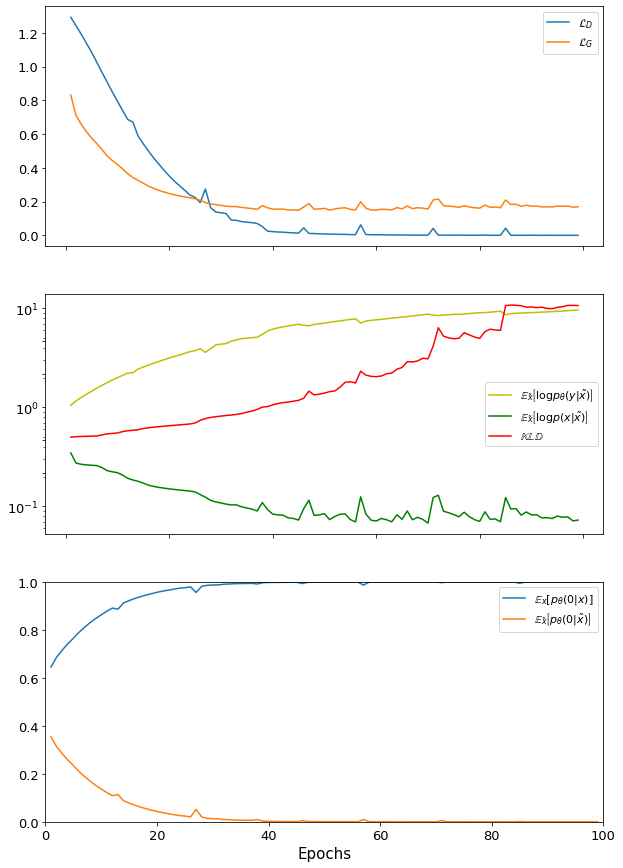

In [18]:
import matplotlib

matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
matplotlib.rc('legend', fontsize=11)  

fig, ax = plt.subplots(3, 1, figsize = (10, 15))
num_epochs = len(d_losses)

plt.xlim(0, num_epochs + 1)
plt.yticks(fontsize=13)
ax[0].plot(range(1, num_epochs + 1), d_losses[:num_epochs], label='$\mathcal{L}_{D}$')
ax[0].plot(range(1, num_epochs + 1), g_losses[:num_epochs], label='$\mathcal{L}_{G}$')   
ax[0].legend()

plt.xlim(0, num_epochs + 1)
   
ax[1].plot(range(1, num_epochs + 1), logpdes[:num_epochs], 'y', label=r'$\mathbb{E}_{\tilde{x}}\left[\log p_{\theta} (y|\tilde{x})\right]$')    
ax[1].plot(range(1, num_epochs + 1), logpyes[:num_epochs], 'green', label=r'$\mathbb{E}_{\tilde{x}}\left[\log p(x|\tilde{x})\right]$') 
ax[1].plot(range(1, num_epochs + 1), kldes[:num_epochs], 'red', label=r'$\mathbb{KLD}$') 
ax[1].set_yscale('log')
ax[1].set_yticks(np.logspace(-1, 1, 7))
ax[1].legend()


plt.xlim(0, num_epochs + 1)
plt.ylim(0, 1)
ax[2].plot(range(1, num_epochs + 1), real_scores[:num_epochs], label=r'$\mathbb{E}_{x}\left[p_{\theta} (0|x)\right]$')  
ax[2].plot(range(1, num_epochs + 1), fake_scores[:num_epochs], label=r'$\mathbb{E}_{\tilde{x}}\left[p_{\theta} (0|\tilde{x})\right]$')
ax[2].legend()

for ax in ax.flat:
    ax.label_outer()
    
plt.xlabel('Epochs', fontsize=15)

plt.savefig('loss_RUNFalse.pdf')

In [19]:
torch.save(model.G.state_dict(), './ARN_G_MNIST.ckpt')
torch.save(model.D.state_dict(), './ARN_D_MNIST.ckpt')

In [15]:
#model.D.load_state_dict(torch.load('./ARN_D_MNIST.ckpt', map_location=torch.device(device)))
#model.G.load_state_dict(torch.load('./ARN_G_MNIST.ckpt', map_location=torch.device(device)))

<All keys matched successfully>

In [20]:
def plot(real, real_bin, fake, prob, real_scores, fake_scores, num_images = 10, title = '', save = False):
    real = real.numpy()
    real_bin = real_bin.numpy()    
    fake = fake.numpy()
    prob = prob.numpy()
    fig = plt.figure(figsize=(30, 15))
    #fig.tight_layout(pad=3.0)
    
    for i in range(num_images):
        # display original images
        ax = plt.subplot(4, num_images, i + 1)
        plt.imshow(real[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        
        
        # display probs
        ax = plt.subplot(4, num_images, i + 1 + num_images)
        plt.imshow(prob[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #plt.subplots_adjust(hspace=0.5)

        # display original images (binarized)
        ax = plt.subplot(4, num_images, i + 1 + 2*num_images)
        plt.imshow(real_bin[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(r'$p_{\theta}(0)$=' + f'{real_scores[i].item():.2f}', fontsize = 10)
        
        #plt.subplots_adjust(hspace=0.5)

        # display encoded images
        ax = plt.subplot(4, num_images, i + 1 + 3*num_images)
        plt.imshow(fake[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(r'$p_{\theta}(0)$=' + f'{fake_scores[i].item():.2f}', fontsize = 10)
        #plt.subplots_adjust(hspace=0.5)
    
    if save:
        plt.savefig(f'{title}.pdf')    
    plt.show()
    

In [23]:
iterator = iter(test_loader)

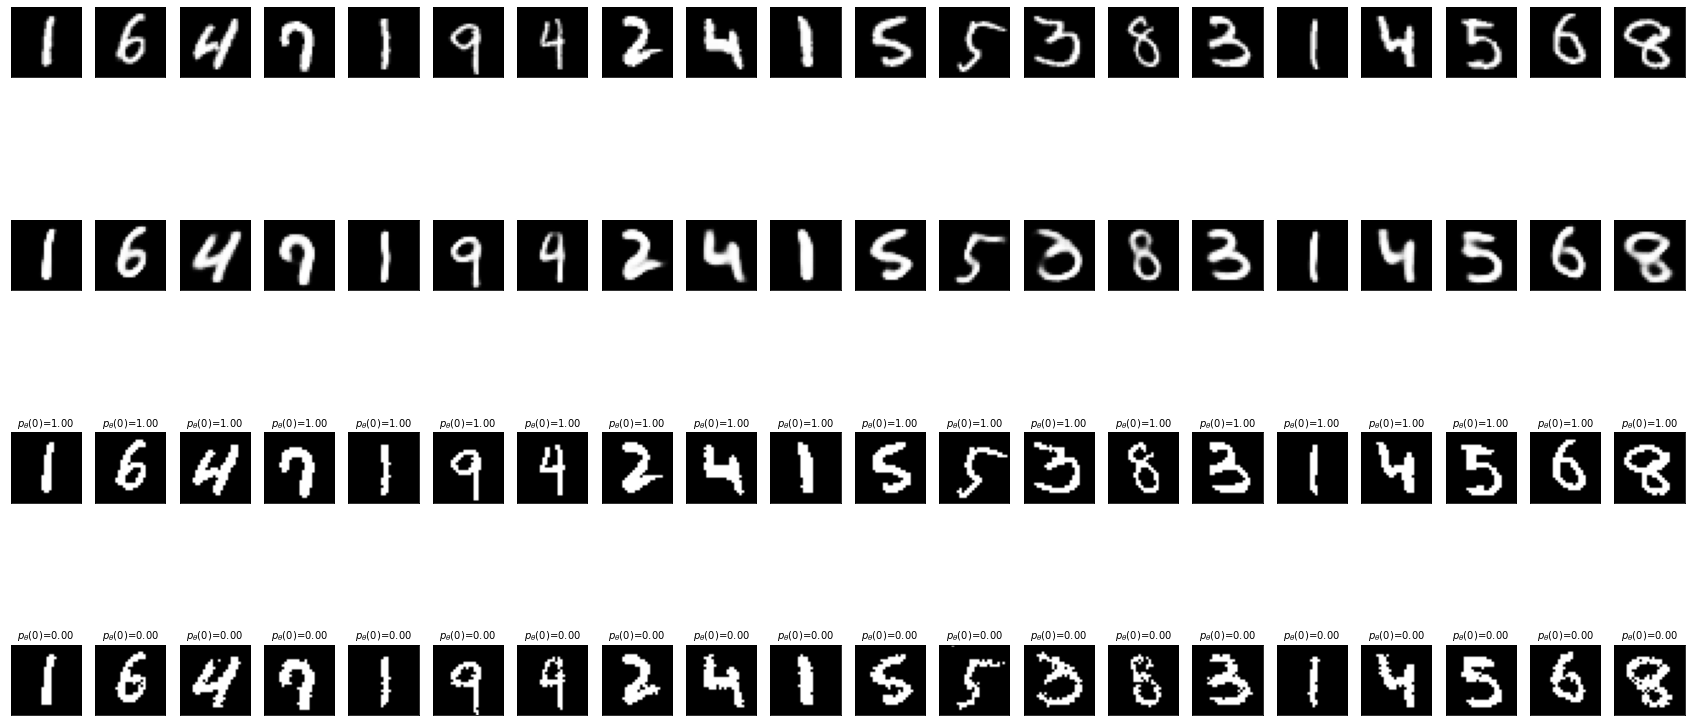

In [27]:
batch, _ = iterator.next()
batch = batch.to(device)

model.G.eval()
model.D.eval()

with torch.no_grad():
    batch_bin = (batch > thresh).float()
    logits,_, _, fake = model.G(batch_bin)
    probs = torch.sigmoid(logits)
    
    
    real_sc = model.D(batch_bin)
    fake_sc = model.D(fake)
    
    plot(batch.cpu(), batch_bin.cpu(), fake.cpu(), probs.cpu(), real_sc.cpu(), fake_sc.cpu(), num_images=20, title = 'IMAGE_RFALSE-Copy1', save = True)